In [971]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import tweepy
import praw
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk.tokenize import TweetTokenizer
from nltk import word_tokenize
import string
from nltk.corpus import stopwords
import datetime
from nltk import punkt
import csv
import math
import os

In [972]:
btc = pd.read_csv('bitcoin.csv')
cc = pd.read_csv('cryptocurrency.csv')
cm = pd.read_csv('cryptomarkets.csv')
gmin = pd.read_csv('gaming.csv')
pcmr = pd.read_csv('pcmasterrace.csv')

price = pd.read_csv('finalized_data.csv')

In [973]:
btc['time'] = pd.to_datetime(btc['time'])
cc['time'] = pd.to_datetime(cc['time'])
cm['time'] = pd.to_datetime(cm['time'])
gmin['time'] = pd.to_datetime(gmin['time'])
pcmr['time'] = pd.to_datetime(pcmr['time'])
price['Time'] = pd.to_datetime(price['Time'])

#remove all posts with no sentiment
btc = btc[btc.compund != 0]
cc = cc[cc.compund != 0]
cm = cm[cm.compund != 0]
gmin = gmin[gmin.compund != 0]
pcmr = pcmr[pcmr.compund != 0]

#remove all none important dates
btc = btc[btc.time >= '04/09/2018']
cc = cc[cc.time >= '04/09/2018']
cm = cm[cm.time >= '04/09/2018']
gmin = gmin[gmin.time >= '04/09/2018']
pcmr = pcmr[pcmr.time >= '04/09/2018']

#combine the crypto subreddit data and gaming data
crypto_list = [btc, cc, cm]
gaming_list = [gmin, pcmr]

crypto = pd.concat(crypto_list)
gaming = pd.concat(gaming_list)

#reduce price to just Time and Coinbase
price = price.filter(['Time', 'coinbase'], axis=1)

#show how data is stored
crypto.info()
gaming.info()
price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1067 entries, 0 to 1034
Data columns (total 8 columns):
text       1067 non-null object
neg        1067 non-null float64
neu        1067 non-null float64
pos        1067 non-null float64
compund    1067 non-null float64
score      1067 non-null int64
golds      1067 non-null int64
time       1067 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 75.0+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1867 entries, 3 to 1172
Data columns (total 8 columns):
text       1867 non-null object
neg        1867 non-null float64
neu        1867 non-null float64
pos        1867 non-null float64
compund    1867 non-null float64
score      1867 non-null int64
golds      1867 non-null int64
time       1867 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 131.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total

In [974]:
#split sentiments into hours
#it is a groupby object so to access the elements you can 
#loop over with a for loop for each hour and dataframe pair
'''
example
for datehour, df in crypto_hours:
    datehour will be the key so 04/09 0:00
    and df will be the observations within that hour
'''
def hour_split(df):
    df['date'] = df['time'].dt.date
    df['hour'] = df['time'].dt.hour
    grps = df.groupby(['date', 'hour'])
    
    return grps

In [975]:
#get mean sentiment for each hour
#returns the hours array and the means array
#the indexes match up like
# 04/09 0:00 ---> .26746
def get_mean(grp):
    hours = []
    means = []
    for hour, df in grp:
        add_hour = datetime.time(hour=hour[1].item())
        hours.append(datetime.datetime.combine(hour[0], add_hour))
        means.append(df.compund.mean())
        
    return hours, means

In [976]:
#get changes in mean sentiment by hour
#returns a list that matches the dates returned
#by the get_mean array
def get_change_mean(means):
    change = []
    for i in range(0, len(means)-1):
        change.append(means[i+1] - means[i])
    
    change.append(np.mean(change[-3:]))
    
    return change

In [977]:
#adds a column to price that stores the change in price
price['change'] = price['coinbase'] - price['coinbase'].shift(-1)
price['change'] = price['change'].fillna(price['change'].mean())
price['change'] = -price['change']

In [978]:
crypto_hours = hour_split(crypto)
gaming_hours = hour_split(gaming)

In [979]:
crypto_dates, crypto_means = get_mean(crypto_hours)
gaming_dates, gaming_means = get_mean(gaming_hours)

print crypto_means[0], crypto_dates[0]
print gaming_means[0], gaming_dates[0]

0.26746 2018-04-09 00:00:00
0.06255 2018-04-09 02:00:00


In [980]:
#get changes in means
crypto_change = get_change_mean(crypto_means)
gaming_change = get_change_mean(gaming_means)

In [981]:
#converted lists to dataframe for ease of use
cdf2 = pd.DataFrame({'time': crypto_dates, 'mean' : crypto_means, 'change': crypto_change})
gdf2 = pd.DataFrame({'time': gaming_dates, 'mean' : gaming_means, 'change': gaming_change})

cdf2.set_index('time')
gdf2.set_index('time')


,change,mean
time,,
2018-04-09 02:00:00,-0.134136,0.062550
2018-04-09 03:00:00,0.352171,-0.071586
2018-04-09 04:00:00,0.127400,0.280586
2018-04-09 05:00:00,-0.378663,0.407986
2018-04-09 06:00:00,0.033378,0.029322
2018-04-09 07:00:00,0.172617,0.062700
2018-04-09 08:00:00,0.028974,0.235317
2018-04-09 09:00:00,0.244984,0.264291
2018-04-09 10:00:00,-0.439125,0.509275


In [982]:
#prepare price for use with hourly data
#only keep the hours we have data for
price_crypto = price[price['Time'].isin(crypto_dates)]
price_gaming = price[price['Time'].isin(gaming_dates)]

In [983]:
#add a label to each row in the dataframes for pos/neg/neu
def labeling(row):
    if row['compund'] >= .2:
        return 'POS'
    elif row['compund'] <= 0:
        return 'NEG'
    else:
        return 'NEU'

    
crypto['label'] = crypto.apply(lambda row: labeling(row), axis=1)
gaming['label'] = gaming.apply(lambda row: labeling(row), axis=1)
crypto.head()
gaming.head()
crypto.head()

,text,neg,neu,pos,compund,score,golds,time,date,hour,label
0,Price Boost History Side,0.000,0.526,0.474,0.4019,1,0,2018-04-12 00:09:00,2018-04-12,0,POS
2,Illegal Trading Flourishing India RBI Ban,0.643,0.357,0.000,-0.8020,0,0,2018-04-11 23:44:00,2018-04-11,23,NEG
4,Good news USA Japan,0.000,0.508,0.492,0.4404,1,0,2018-04-11 23:24:00,2018-04-11,23,POS
5,Hey guys made cool Apparel feedback would grea...,0.000,0.543,0.457,0.7089,1,0,2018-04-11 23:21:00,2018-04-11,23,POS
6,Today got lightning sticker blockstream really...,0.000,0.782,0.218,0.4201,1,0,2018-04-11 23:19:00,2018-04-11,23,POS


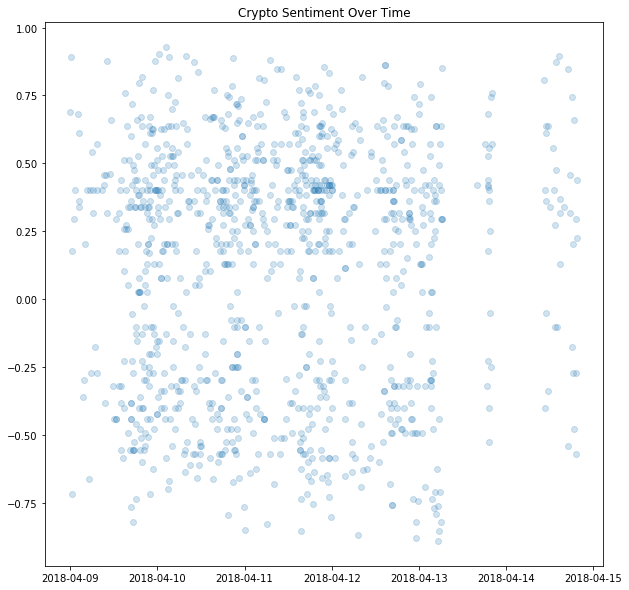

In [984]:
#raw crypto sentiment over time
fig, ax = plt.subplots(figsize=(10,10))
ax.plot_date(crypto['time'], crypto['compund'], alpha=0.2)
ax.set(title='Crypto Sentiment Over Time')
plt.show()

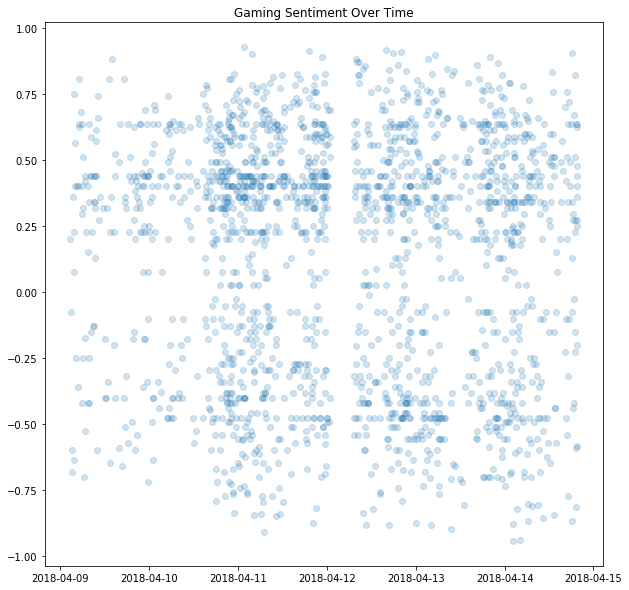

In [985]:
#raw gaming sentiment over time
fig, ax = plt.subplots(figsize=(10,10))
ax.plot_date(gaming['time'], gaming['compund'], alpha=0.2)
ax.set(title='Gaming Sentiment Over Time')
plt.show()

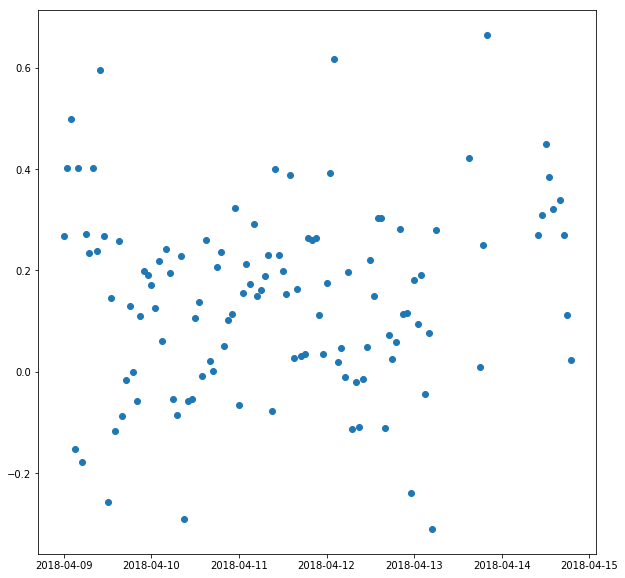

In [986]:
#Sentiment average by hour crypto
fig, ax = plt.subplots(figsize=(10,10))
ax.plot_date(crypto_dates, crypto_means)
plt.show()


,text,neg,neu,pos,compund,score,golds,time,date,hour,label
0,Price Boost History Side,0.000,0.526,0.474,0.4019,1,0,2018-04-12 00:09:00,2018-04-12,0,POS
2,Illegal Trading Flourishing India RBI Ban,0.643,0.357,0.000,-0.8020,0,0,2018-04-11 23:44:00,2018-04-11,23,NEG
4,Good news USA Japan,0.000,0.508,0.492,0.4404,1,0,2018-04-11 23:24:00,2018-04-11,23,POS
5,Hey guys made cool Apparel feedback would grea...,0.000,0.543,0.457,0.7089,1,0,2018-04-11 23:21:00,2018-04-11,23,POS
6,Today got lightning sticker blockstream really...,0.000,0.782,0.218,0.4201,1,0,2018-04-11 23:19:00,2018-04-11,23,POS
7,Credit Card Scammers Street Gangs Dark Web,0.000,0.698,0.302,0.3818,1,0,2018-04-11 23:18:00,2018-04-11,23,POS
8,truthful fearless gentle Gandhi,0.000,0.102,0.898,0.8316,0,0,2018-04-11 23:12:00,2018-04-11,23,POS
10,Alright,0.000,0.000,1.000,0.2500,4,0,2018-04-11 23:11:00,2018-04-11,23,POS
11,make JPMorgan busted fraud,0.559,0.441,0.000,-0.5859,9,0,2018-04-11 23:10:00,2018-04-11,23,NEG
17,Member people actually saved hodl,0.000,0.588,0.412,0.4215,1,0,2018-04-11 22:38:00,2018-04-11,22,POS


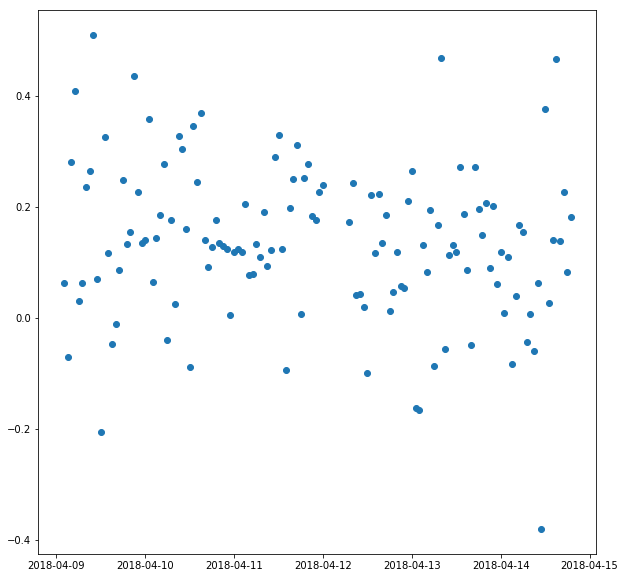

In [987]:
#Sentiment average by hour gaming
fig, ax = plt.subplots(figsize=(10,10))
ax.plot_date(gaming_dates, gaming_means)
plt.plot()
crypto.head(20)

144

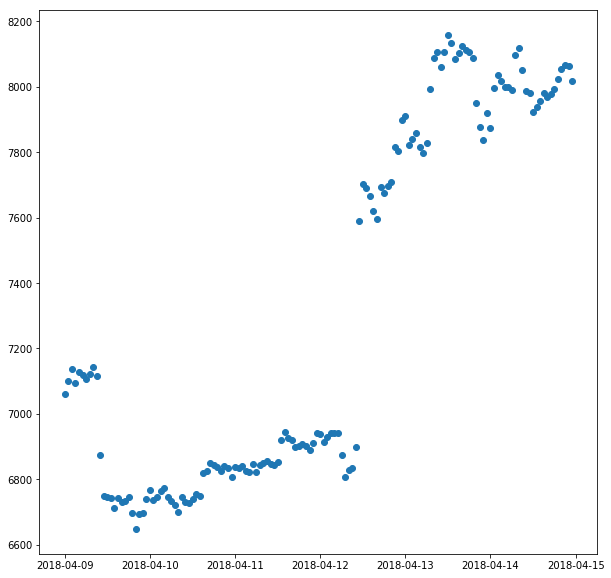

In [988]:
#bitcoin price
fig, ax = plt.subplots(figsize=(10,10))
ax.plot_date(price['Time'], price['coinbase'])
plt.plot()
len(price)

In [989]:
print price.iloc[price['change'].idxmax()]

Time        2018-04-12 10:00:00
coinbase                6897.34
change                   691.43
Name: 82, dtype: object


In [990]:
print cdf2[cdf2['time'] == datetime.datetime(2018,4,12,10)]
print gdf2[gdf2['time'] == datetime.datetime(2018,4,12,10)]

     change    mean                time
82  0.06325 -0.0148 2018-04-12 10:00:00
      change      mean                time
74 -0.024952  0.043405 2018-04-12 10:00:00


In [991]:
#change in sentiment vs. change in price


In [992]:
#sentiment vs. price

In [993]:
##############REGRESSSION#################

# Linear Regression Starts Here.



# Setting up Dataframes
Breaking Down the DataFrames for Crypto and Gaming subs to categorize by date and hour.

Then we mean all the compound values for each hour and store it in the DataFrames for each date

Then we add numeric values to sentiments -50,0,50 depending on neg,neu,pos respectively


In [1056]:
###############
#
#Group data by time hours, then merge with price Change [GROUPS BY DATE AND HOUR]
#SMall sample size
#Represent Labels sentimets by numbers
#
################value
def hour_split_lower(df):
    df['date'] = df['Time'].dt.date
    df['hour'] = df['Time'].dt.hour
    df = df.drop(['Time'], axis=1)
    df = df[['date', 'hour','coinbase','change']].copy()
    return df

##give numbers to the label for better visual representation

def numeric_labels(row):
    l = 50
    if row['label'] == 'POS':
        return l
    elif row['label'] == 'NEG':
        return -l
    else:
        return 0

crypto_grouped = crypto.groupby(['date', 'hour']).mean().reset_index() #Grab mean of compound for hour of each Date
gaming_grouped = gaming.groupby(['date', 'hour']).mean().reset_index()
price_grouped = hour_split_lower(price)
price_grouped = price_grouped.groupby(['date', 'hour']).mean().reset_index().copy() 
crypto_price = pd.merge(crypto_grouped, price_grouped,  how='left', left_on=['date','hour'], right_on = ['date','hour']).copy()
gaming_price = pd.merge(gaming_grouped, price_grouped,  how='left', left_on=['date','hour'], right_on = ['date','hour']).copy()

gaming_price['label'] = gaming_price.apply(lambda row: labeling(row), axis=1)
gaming_price['n_label'] = gaming_price.apply(lambda row: numeric_labels(row), axis=1)

crypto_price['label'] = crypto_price.apply(lambda row: labeling(row), axis=1)
crypto_price['n_label'] = crypto_price.apply(lambda row: numeric_labels(row), axis=1)
crypto_price.head(5)


,date,hour,neg,neu,pos,compund,score,golds,coinbase,change,label,n_label
0,2018-04-09,0,0.150000,0.48720,0.362800,0.267460,294.4,0.0,7060.724767,39.497922,POS,50
1,2018-04-09,1,0.000000,0.59700,0.403000,0.401900,80.0,0.0,7100.222689,38.055096,POS,50
2,2018-04-09,2,0.000000,0.49675,0.503250,0.498600,13.5,0.0,7138.277785,-44.277796,POS,50
3,2018-04-09,3,0.123667,0.77900,0.097333,-0.151633,31.0,0.0,7093.999989,32.630909,NEG,-50
4,2018-04-09,4,0.000000,0.52600,0.474000,0.401900,159.0,0.0,7126.630898,-6.767970,POS,50


# Breaking Down dates into Hours
With all the data gathered, we break down the range of dates into hours. We do so by converting the hour tabs into a continious form from 0 to max Number of Dates X hours. 

Our DataFrame is already sorted by date and hours for each date. So we can simply convert the hours to continious format and drop the Date



In [1055]:
## Hourly BreakDown from dates  2018-04-09 to 2018-04-14

crypto_price_hourly = pd.DataFrame({'Hours': np.arange(len(crypto_price)), 'change': crypto_price['change'],
                       'compund':  crypto_price['compund'],'change': crypto_price['change'],'price':crypto_price['coinbase'],
                                    'label':crypto_price['label'], 'n_label':crypto_price['n_label']})

gaming_price_hourly = pd.DataFrame({'Hours': np.arange(len(gaming_price)), 'change': gaming_price['change'],
                       'compund':  gaming_price['compund'],'price':gaming_price['coinbase'],
                                    'n_label':gaming_price['n_label'], 'label':gaming_price['label']})
gaming_price_hourly.head(5)

,Hours,change,compund,label,n_label,price
0,0,-44.277796,0.062550,NEU,0,7138.277785
1,1,32.630909,-0.071586,NEG,-50,7093.999989
2,2,-6.767970,0.280586,POS,50,7126.630898
3,3,-11.859720,0.407986,POS,50,7119.862928
4,4,14.214823,0.029322,NEU,0,7108.003208


In [996]:
#REGRESSIONS START HERE
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
plt.rcParams['figure.figsize'] = 7,7

# Graph that shows Price changes Over the Hours

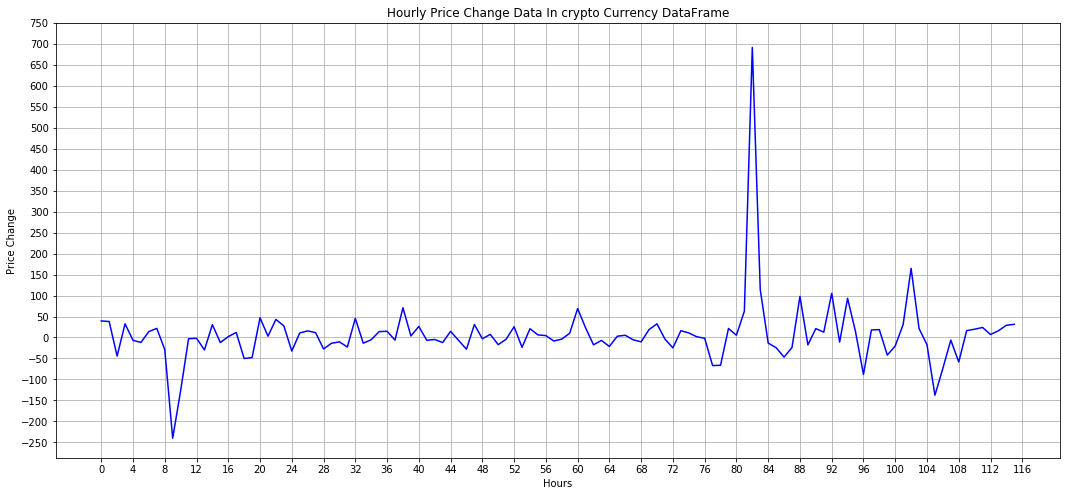

In [997]:
##########
# Hourly Price Change for Crypto
##########
plt.rcParams['figure.figsize'] = 18,8
plt.plot(crypto_price_hourly['Hours'],crypto_price_hourly['change'],  color='blue')
plt.xticks(np.arange(0, len(crypto_price_hourly)+1, 4))
plt.yticks(np.arange(-250, crypto_price_hourly['change'].max()+100, 50))
plt.grid()
plt.title('Hourly Price Change Data In crypto Currency DataFrame')
plt.xlabel('Hours')
plt.ylabel('Price Change')
plt.show()


# Linear Regression: Our Research relies on Sentiment. 

Our whole reseach relies on the dependency of a variable on another known Variable. As such, Linear regression was the best regression model for us.

Aother reason for a linear Regression Model is that, out sample Sizes after pre-processing are less than 150. Running other models like Logistic Regression would provide low Accuracy Results

We fit the model using the current Data that we Have on Crypto and Gaming subredding Sentiment

We are predicting Price change, not the amount of change. As such, we needed to make sure our variables we clear to indicate what's going on.

The predicted Values had to be re-altered for visual representation. n_label is just numbering for the sentiment. We had to re-evaluate to fix visual disperancy 


In [998]:
###
# Crypto Sentiment: Create Linear Regression
# number positive and negative sentiments by numbers (Range -50 0, 50)
#
###
lm = LinearRegression()
changesC = []
hourly_compound_crypto = crypto_price_hourly['n_label'].values.reshape(-1,1)
hourly_change_crypto = crypto_price_hourly['change'].values.reshape(-1,1)
  
lm.fit(hourly_compound_crypto,hourly_change_crypto)
predicted_hourly_change = lm.predict(hourly_compound_crypto)
for i in (predicted_hourly_change):
    if i<0:
        changesC.append(50)
    elif i >15:
        changesC.append(-50)
    else:
        changesC.append(0)


# Using the Fitted model For Crypto

Sentiment is something that changes over time. We acknowledged the fact that users weren't always around their laptops/Desktops. We decided to add a delay to mitigate this.


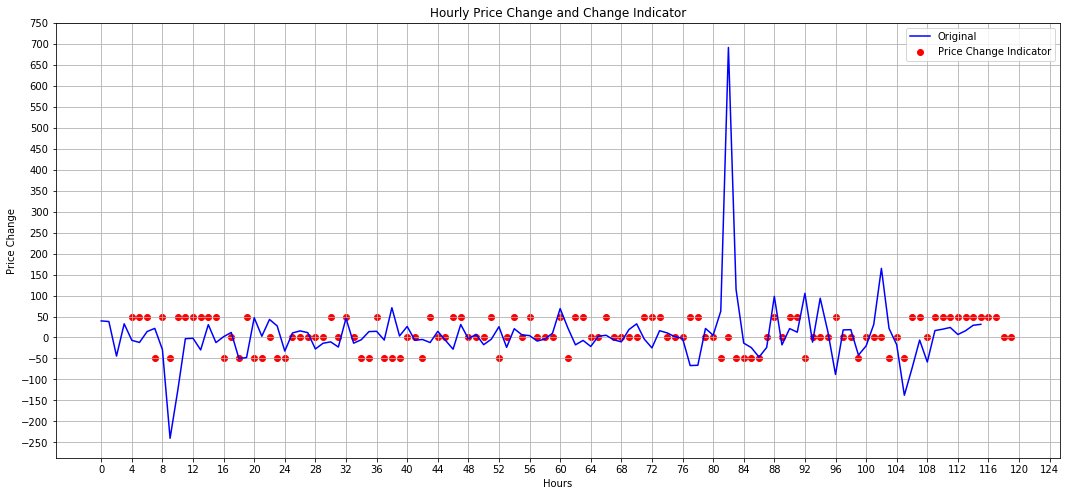

In [1044]:
n = 4
#
# Fit predicted model over the original with a time difference for prediction to take place 
#
plt.rcParams['figure.figsize'] = 18,8
new_hours = np.arange(n,crypto_price_hourly['Hours'].max()+n+1,1)

plt.plot(crypto_price_hourly['Hours'],crypto_price_hourly['change'],  color='blue', label ='Original')
plt.scatter(new_hours, changesC, label ='Price Change Indicator', color='red')

plt.xticks(np.arange(0, len(crypto_price_hourly)+10, 4))
plt.yticks(np.arange(-250, crypto_price_hourly['change'].max()+100, 50))
plt.rcParams['figure.figsize'] = 20,15
plt.grid()
plt.title('Hourly Price Change and Change Indicator')
plt.xlabel('Hours')
plt.ylabel('Price Change')
plt.legend()

plt.show()
print 


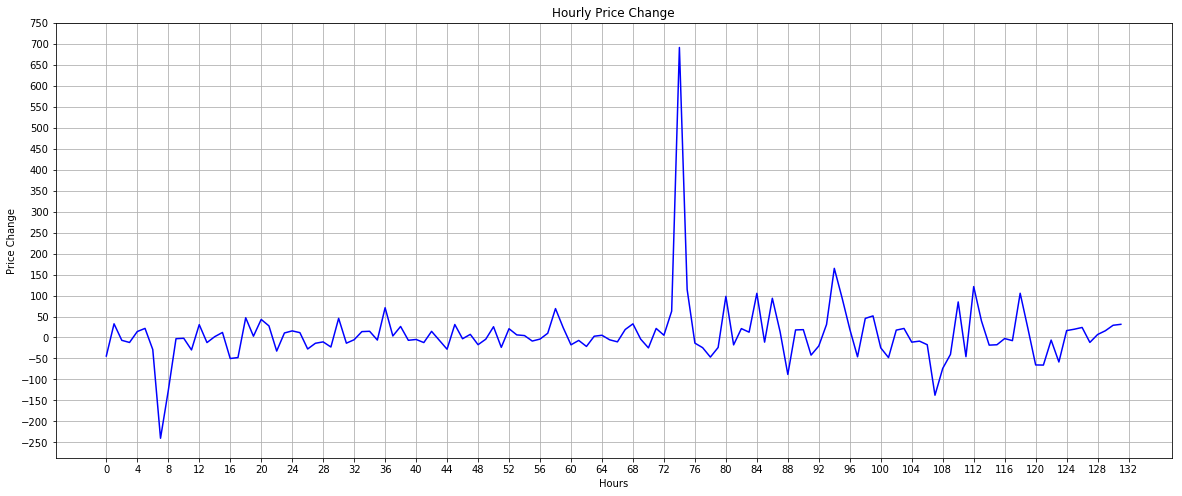

In [1000]:
##########
# Hourly Price Change for gaming
##########
plt.rcParams['figure.figsize'] = 20,8
plt.plot(gaming_price_hourly['Hours'],gaming_price_hourly['change'],  color='blue')
plt.xticks(np.arange(0, len(gaming_price_hourly)+1, 4))
plt.yticks(np.arange(-250, gaming_price_hourly['change'].max()+100, 50))
plt.grid()
plt.title('Hourly Price Change')
plt.xlabel('Hours')
plt.ylabel('Price Change')
plt.show()


In [1011]:
###
# Gaming Sentiment: Create Linear Regression
# number positive and negative sentiments by numbers (Range -50 0, 50)
# 
###
lm = LinearRegression()
changes = []
hourly_compound_gaming = gaming_price_hourly['n_label'].values.reshape(-1,1)
hourly_change_gaming = gaming_price_hourly['change'].values.reshape(-1,1)
  
lm.fit(hourly_compound_gaming,hourly_change_gaming)
predicted_hourly_change = lm.predict(hourly_compound_gaming)
for i in (predicted_hourly_change):
    if i<0:
        changes.append(50)
    elif i >15:
        changes.append(-50)
    else:
        changes.append(0)


# Making a model for Gaming Subreddit 


132


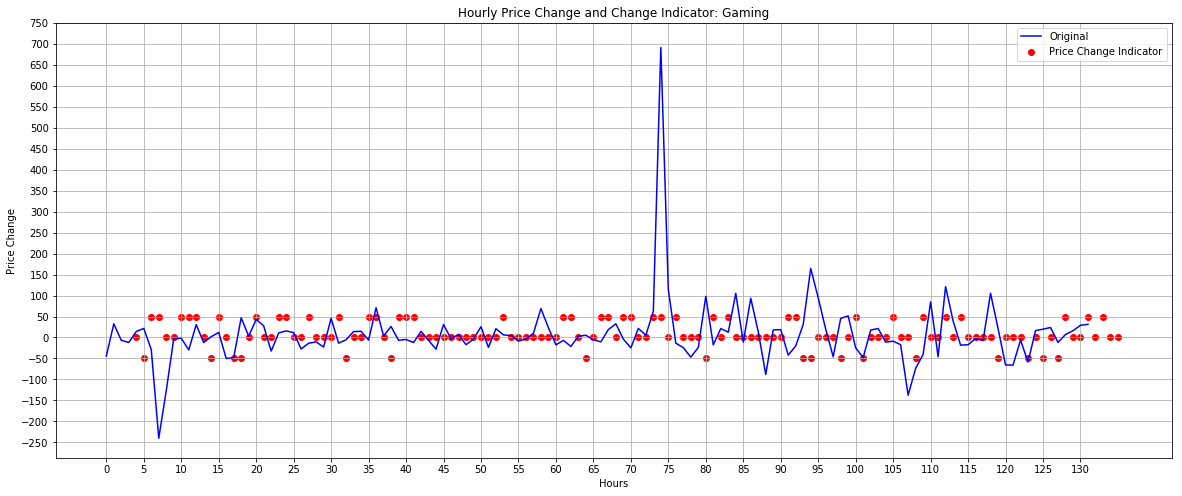

In [1045]:
n = 4 # Hours to wait for modeling to kick in

##########
# Fit Model over Gaming
##########
plt.rcParams['figure.figsize'] = 20,8

new_hours = np.arange(n,gaming_price_hourly['Hours'].max()+n+1,1)
print len(new_hours)
plt.plot(gaming_price_hourly['Hours'],gaming_price_hourly['change'],  color='blue',label='Original')
#plt.plot(new_hours,predicted_hourly_change,  color='red', label ='Predicted')
plt.scatter(new_hours, changes, label ='Price Change Indicator', color='red')
plt.xticks(np.arange(0, len(gaming_price_hourly)+1, 5))
plt.yticks(np.arange(-250, gaming_price_hourly['change'].max()+100, 50))
plt.grid()
plt.legend()
plt.title('Hourly Price Change and Change Indicator: Gaming')
plt.xlabel('Hours')
plt.ylabel('Price Change')
plt.show()

# Fitting the predicted Model we got from Gaming Subreddit onto the Crypto

Bitcoin is discussed in both subs and should have similar reactions given the fact that PC systems are one of the major bitcoin mining systems. Plotting the predictions we got from GAMING subs over crtypto subs should give us a better accuracy check since the DATA TIME FRAME was the same for both

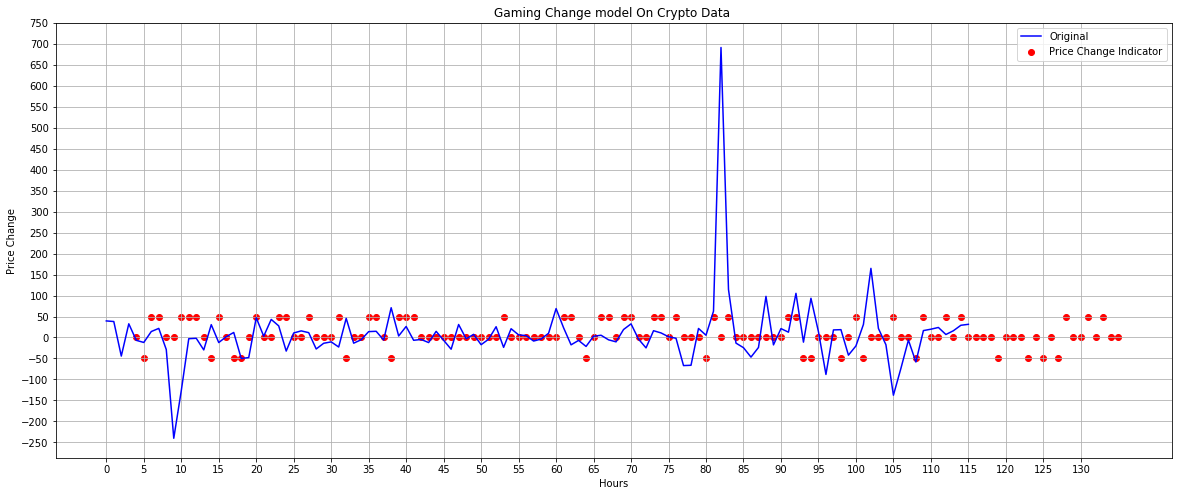

In [1047]:
n = 4
new_hours = np.arange(n,gaming_price_hourly['Hours'].max()+n+1,1)
plt.plot(crypto_price_hourly['Hours'],crypto_price_hourly['change'],  color='blue',label='Original')
plt.scatter(new_hours, changes, label ='Price Change Indicator', color='red')
plt.xticks(np.arange(0, len(gaming_price_hourly)+1, 5))
plt.yticks(np.arange(-250, gaming_price_hourly['change'].max()+100, 50))
plt.grid()
plt.legend()
plt.title('Gaming Change model On Crypto Data ')
plt.xlabel('Hours')
plt.ylabel('Price Change')
plt.show()

# SNS and REG plots

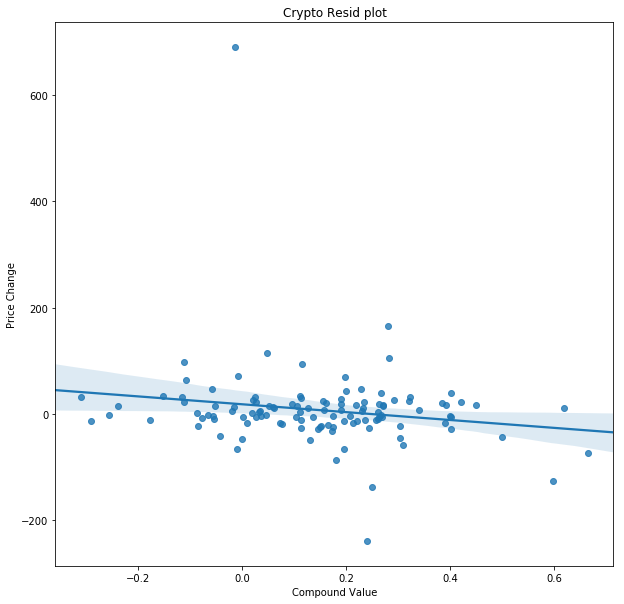

In [1052]:
sns.regplot('compund', 'change', crypto_price_hourly , fit_reg=True )
plt.rcParams['figure.figsize'] = 10,10
plt.title('Crypto Resid plot')
plt.xlabel('Compound Value')
plt.ylabel('Price Change')
plt.show()


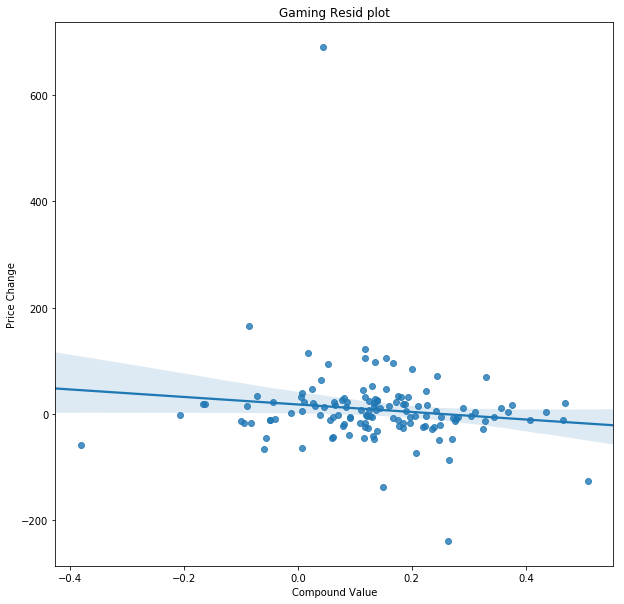

In [1050]:
sns.regplot('compund', 'change', gaming_price_hourly , fit_reg=True )
plt.rcParams['figure.figsize'] = 10,10
plt.title('Gaming Resid plot')
plt.xlabel('Compound Value')
plt.ylabel('Price Change')
plt.show()


# Checking R-squared Values And Correlations 

In [1102]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
res = smf.ols(formula='change ~ label', data=crypto_price_hourly).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 change   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     2.338
Date:                Fri, 20 Apr 2018   Prob (F-statistic):              0.101
Time:                        22:14:24   Log-Likelihood:                -668.94
No. Observations:                 116   AIC:                             1344.
Df Residuals:                     113   BIC:                             1352.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       35.9604     15.665      2.296      0.024       4.924      66.996
label[T.NEU]   -32.6527     19.389     -1.684      0.095     -71.066       5.761
label[T.POS]   -41.6446     19.617     -2.123      0.036     -80.510      -2.779
==============================================================================
Omnibus:                      162.588   Durbin-Watson:                   1.559
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9345.525
Skew:                           5.023   Prob(JB):                         0.00
Kurtosis:                      45.809   Cond. No.                         4.57
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1104]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
res = smf.ols(formula='change ~ label', data=gaming_price_hourly).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 change   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     2.491
Date:                Fri, 20 Apr 2018   Prob (F-statistic):             0.0868
Time:                        22:18:59   Log-Likelihood:                -757.55
No. Observations:                 132   AIC:                             1521.
Df Residuals:                     129   BIC:                             1530.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.0722     18.448      0.058      0.954     -35.428      37.573
label[T.NEU]    18.6049     20.383      0.913      0.363     -21.724      58.934
label[T.POS]   -14.5400     22.195     -0.655      0.514     -58.453      29.373
==============================================================================
Omnibus:                      184.031   Durbin-Watson:                   1.607
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12463.059
Skew:                           5.220   Prob(JB):                         0.00
Kurtosis:                      49.444   Cond. No.                         6.05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

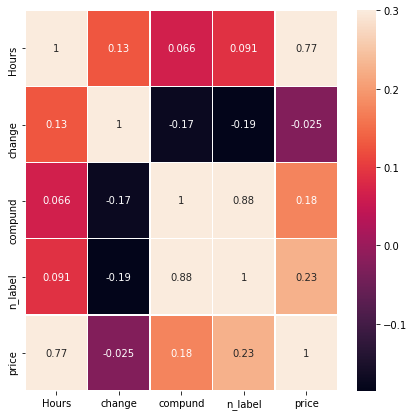

In [1117]:
#dummydf =days[['season', 'holiday', 'weathersit','temp','atemp','hum','windspeed','casual','registered','cnt']].copy()
corr =crypto_price_hourly.corr()

sns.heatmap(corr,vmax=0.3,linewidth=0.5,annot=True)  
plt.rcParams['figure.figsize'] = 7, 7

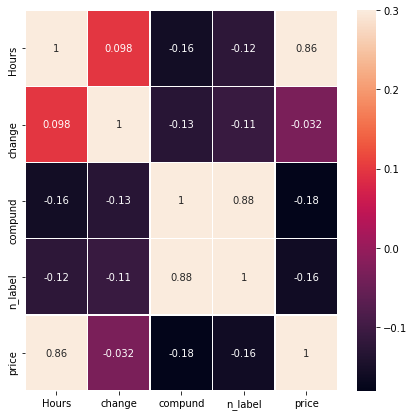

In [1116]:
#dummydf =days[['season', 'holiday', 'weathersit','temp','atemp','hum','windspeed','casual','registered','cnt']].copy()
corr =gaming_price_hourly.corr()

sns.heatmap(corr,vmax=0.3,linewidth=0.5,annot=True)  
plt.rcParams['figure.figsize'] = 7, 7